<a href="https://colab.research.google.com/github/andjelatodorovich/notebooks/blob/master/Research_project_privacy_and_fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_privacy

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import sys
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
import time
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise


from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting

import numpy as np
import scipy as scp
from scipy import special

import matplotlib.pyplot as plt
%matplotlib inline


random_state = 100
test_size = 0.3

In [3]:
data = pd.read_csv("adult.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
data.head(15)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


In [5]:
#Data preprocessing and removal of NaN values and unwanted columns

In [6]:
data.replace("?", np.NaN, inplace = True)
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [7]:
data.drop(["education"], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education.num   32561 non-null  int64 
 4   marital.status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital.gain    32561 non-null  int64 
 10  capital.loss    32561 non-null  int64 
 11  hours.per.week  32561 non-null  int64 
 12  native.country  31978 non-null  object
 13  income          32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [8]:
data.workclass.unique()

array([nan, 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [9]:
data.workclass.fillna("Other", inplace = True)

In [10]:
data.occupation.unique()

array([nan, 'Exec-managerial', 'Machine-op-inspct', 'Prof-specialty',
       'Other-service', 'Adm-clerical', 'Craft-repair',
       'Transport-moving', 'Handlers-cleaners', 'Sales',
       'Farming-fishing', 'Tech-support', 'Protective-serv',
       'Armed-Forces', 'Priv-house-serv'], dtype=object)

In [11]:
data.occupation.fillna("Unknown", inplace = True)

In [12]:
data["native.country"].fillna("Other", inplace = True)

In [13]:
#Handling cathegorical data and setting up binary classification goals

In [14]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [15]:
workclass_mapper = {key: value for value, key in enumerate(data.workclass.unique())}
marital_status_mapper = {key: value for value, key in enumerate(data["marital.status"].unique())}
occupation_mapper = {key: value for value, key in enumerate(data.occupation.unique())}
relationship_mapper = {key: value for value, key in enumerate(data.relationship.unique())}
race_mapper = {key: value for value, key in enumerate(data.race.unique())}
sex_mapper = {key: value for value, key in enumerate(data.sex.unique())}
native_country_mapper = {key: value for value, key in enumerate(data["native.country"].unique())}

data.workclass = data.workclass.map(workclass_mapper)
data["marital.status"] = data["marital.status"].map(marital_status_mapper)
data.occupation = data.occupation.map(occupation_mapper)
data.relationship = data.relationship.map(relationship_mapper)
data.race = data.race.map(race_mapper)
data.sex = data.sex.map(sex_mapper)
data["native.country"] = data["native.country"].map(native_country_mapper)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  int64 
 2   fnlwgt          32561 non-null  int64 
 3   education.num   32561 non-null  int64 
 4   marital.status  32561 non-null  int64 
 5   occupation      32561 non-null  int64 
 6   relationship    32561 non-null  int64 
 7   race            32561 non-null  int64 
 8   sex             32561 non-null  int64 
 9   capital.gain    32561 non-null  int64 
 10  capital.loss    32561 non-null  int64 
 11  hours.per.week  32561 non-null  int64 
 12  native.country  32561 non-null  int64 
 13  income          32561 non-null  object
dtypes: int64(13), object(1)
memory usage: 3.5+ MB


In [16]:
income_mapper = {'<=50K': 0, '>50K': 1}
data.income = data.income.map(income_mapper)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int64
 2   fnlwgt          32561 non-null  int64
 3   education.num   32561 non-null  int64
 4   marital.status  32561 non-null  int64
 5   occupation      32561 non-null  int64
 6   relationship    32561 non-null  int64
 7   race            32561 non-null  int64
 8   sex             32561 non-null  int64
 9   capital.gain    32561 non-null  int64
 10  capital.loss    32561 non-null  int64
 11  hours.per.week  32561 non-null  int64
 12  native.country  32561 non-null  int64
 13  income          32561 non-null  int64
dtypes: int64(14)
memory usage: 3.5 MB


In [17]:
#Training a model with differentially-private optimizer

In [18]:
data.head(10)

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,9,0,0,0,0,0,0,4356,40,0,0
1,82,1,132870,9,0,1,0,0,0,0,4356,18,0,0
2,66,0,186061,10,0,0,1,1,0,0,4356,40,0,0
3,54,1,140359,4,1,2,1,0,0,0,3900,40,0,0
4,41,1,264663,10,2,3,2,0,0,0,3900,40,0,0
5,34,1,216864,9,1,4,1,0,0,0,3770,45,0,0
6,38,1,150601,6,2,5,1,0,1,0,3770,40,0,0
7,74,2,88638,16,3,3,3,0,0,0,3683,20,0,1
8,68,3,422013,9,1,3,0,0,0,0,3683,40,0,0
9,41,1,70037,10,3,6,1,0,1,0,3004,60,1,1


In [19]:
#!pip freeze

In [20]:
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(data.iloc[:, :-1]), columns = data.columns[:-1])
x

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.000000,0.000,0.043987,0.533333,0.000000,0.000000,0.0,0.00,0.0,0.0,1.000000,0.397959,0.0
1,0.890411,0.125,0.081896,0.533333,0.000000,0.071429,0.0,0.00,0.0,0.0,1.000000,0.173469,0.0
2,0.671233,0.000,0.118021,0.600000,0.000000,0.000000,0.2,0.25,0.0,0.0,1.000000,0.397959,0.0
3,0.506849,0.125,0.086982,0.200000,0.166667,0.142857,0.2,0.00,0.0,0.0,0.895317,0.397959,0.0
4,0.328767,0.125,0.171404,0.600000,0.333333,0.214286,0.4,0.00,0.0,0.0,0.895317,0.397959,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.068493,0.125,0.202298,0.600000,0.500000,0.857143,0.0,0.00,1.0,0.0,0.000000,0.397959,0.0
32557,0.136986,0.125,0.166404,0.733333,0.666667,0.785714,1.0,0.00,0.0,0.0,0.000000,0.377551,0.0
32558,0.315068,0.125,0.096500,0.533333,0.666667,0.142857,0.8,0.00,1.0,0.0,0.000000,0.397959,0.0
32559,0.561644,0.125,0.094827,0.533333,0.000000,0.357143,0.2,0.00,0.0,0.0,0.000000,0.397959,0.0


In [21]:
y = data.iloc[:, -1]
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    0
32558    1
32559    0
32560    0
Name: income, Length: 32561, dtype: int64

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)

In [23]:
inputs = tf.keras.Input(shape = (x_train.shape[1],))
x = tf.keras.layers.Dense(16, activation = "relu")(inputs)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)

regular_model = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)
metrics = [
    tf.keras.metrics.BinaryAccuracy(name = "acc"),
    tf.keras.metrics.AUC(name = "auc")
]

regular_model.compile(optimizer, loss = "binary_crossentropy", metrics = metrics)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10)
history = regular_model.fit(x_train, y_train, validation_split = 0.2, batch_size = 50, epochs = 1000, callbacks=[early_stopping])

Epoch 1/1000
365/365 [==============================] - 3s 5ms/step - loss: 0.3855 - acc: 0.8165 - auc: 0.8558 - val_loss: 0.3364 - val_acc: 0.8372 - val_auc: 0.8980
Epoch 2/1000
365/365 [==============================] - 2s 4ms/step - loss: 0.3587 - acc: 0.8318 - auc: 0.8777 - val_loss: 0.3339 - val_acc: 0.8416 - val_auc: 0.9006
Epoch 3/1000
365/365 [==============================] - 2s 4ms/step - loss: 0.3484 - acc: 0.8384 - auc: 0.8854 - val_loss: 0.3562 - val_acc: 0.8372 - val_auc: 0.8983
Epoch 4/1000
365/365 [==============================] - 3s 7ms/step - loss: 0.3489 - acc: 0.8358 - auc: 0.8851 - val_loss: 0.3348 - val_acc: 0.8388 - val_auc: 0.8982
Epoch 5/1000
365/365 [==============================] - 3s 8ms/step - loss: 0.3428 - acc: 0.8423 - auc: 0.8897 - val_loss: 0.3300 - val_acc: 0.8381 - val_auc: 0.9011
Epoch 6/1000
365/365 [==============================] - 3s 8ms/step - loss: 0.3425 - acc: 0.8429 - auc: 0.8898 - val_loss: 0.3364 - val_acc: 0.8394 - val_auc: 0.8999
Epoc

Text(0.5, 0, 'Epochs')

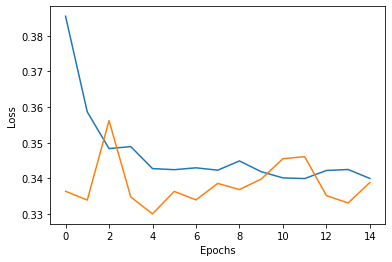

In [25]:
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"])
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

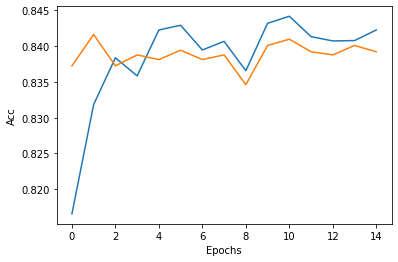

In [26]:
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["acc"])
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["val_acc"])
plt.ylabel("Acc")
plt.xlabel("Epochs")

In [27]:
n = x_train.shape[0]
epochs = 100
batch_size = 50
microbatches = 1
e = 0.1
delta = 1e-6
min_noise = 1e-100
l2_norm_clip = 2.5
sampling_rate = batch_size / n


inputs = tf.keras.Input(shape = (x_train.shape[1],))
x = tf.keras.layers.Dense(16, activation = "relu")(inputs)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)

noise_multiplier = compute_noise(n, batch_size, e, epochs, delta, min_noise)

privacy_perserving_model = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = DPKerasAdamOptimizer(
                            l2_norm_clip=2.5,
                            noise_multiplier=noise_multiplier,
                            num_microbatches=1,
                            learning_rate=1e-4)
metrics = [
    tf.keras.metrics.BinaryAccuracy(name = "acc"),
    tf.keras.metrics.AUC(name = "auc")
]

privacy_perserving_model.compile(optimizer, loss = "binary_crossentropy", metrics = metrics)

DP-SGD with sampling rate = 0.219% and noise_multiplier = 19.43042526381595 iterated over 45584 steps satisfies differential privacy with eps = 0.1 and delta = 1e-06.


In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10)
history = privacy_perserving_model.fit(x_train, y_train, validation_split = 0.2, batch_size = 50, epochs = 1000, callbacks=[early_stopping])

Epoch 1/1000
365/365 [==============================] - 5s 7ms/step - loss: 0.8014 - acc: 0.2472 - auc: 0.6571 - val_loss: 0.7997 - val_acc: 0.2540 - val_auc: 0.6572
Epoch 2/1000
365/365 [==============================] - 2s 6ms/step - loss: 0.8004 - acc: 0.2472 - auc: 0.6559 - val_loss: 0.7982 - val_acc: 0.2544 - val_auc: 0.6554
Epoch 3/1000
365/365 [==============================] - 2s 6ms/step - loss: 0.7989 - acc: 0.2483 - auc: 0.6546 - val_loss: 0.7975 - val_acc: 0.2555 - val_auc: 0.6533
Epoch 4/1000
365/365 [==============================] - 2s 6ms/step - loss: 0.7999 - acc: 0.2484 - auc: 0.6528 - val_loss: 0.7999 - val_acc: 0.2547 - val_auc: 0.6541
Epoch 5/1000
365/365 [==============================] - 2s 6ms/step - loss: 0.8010 - acc: 0.2477 - auc: 0.6533 - val_loss: 0.7985 - val_acc: 0.2558 - val_auc: 0.6525
Epoch 6/1000
365/365 [==============================] - 2s 6ms/step - loss: 0.8007 - acc: 0.2488 - auc: 0.6538 - val_loss: 0.7995 - val_acc: 0.2560 - val_auc: 0.6546
Epoc

Text(0.5, 0, 'Epochs')

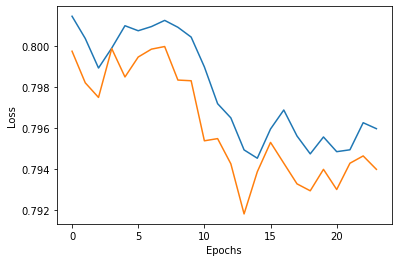

In [29]:
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"])
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

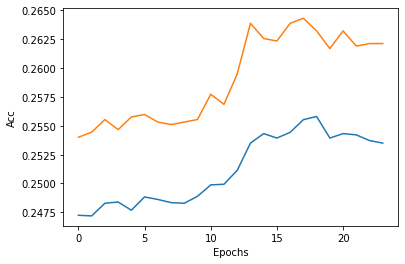

In [30]:
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["acc"])
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["val_acc"])
plt.ylabel("Acc")
plt.xlabel("Epochs")

In [31]:
!pip install fairlearn

In [32]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [33]:
constraints = "demographic_parity"
sensitive_feature = "race"

In [34]:
x_test

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
27144,0.027397,0.125,0.101743,0.533333,0.500000,0.142857,0.4,0.0,1.0,0.0,0.0,0.397959,0.000000
11743,0.356164,0.000,0.070868,0.600000,0.666667,0.000000,0.8,0.0,1.0,0.0,0.0,0.448980,0.000000
4306,0.575342,0.125,0.100278,0.533333,0.666667,0.642857,0.8,0.0,1.0,0.0,0.0,0.479592,0.000000
19590,0.082192,0.125,0.037811,0.600000,0.500000,0.285714,0.0,0.0,0.0,0.0,0.0,0.295918,0.000000
24990,0.191781,0.125,0.109966,0.533333,0.666667,0.500000,0.8,0.0,1.0,0.0,0.0,0.653061,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27595,0.328767,0.125,0.131607,0.600000,0.666667,0.142857,0.8,0.0,1.0,0.0,0.0,0.397959,0.000000
31516,0.246575,0.125,0.065204,0.800000,0.000000,0.214286,0.2,0.0,0.0,0.0,0.0,0.316327,0.000000
18711,0.273973,0.500,0.171813,0.933333,0.666667,0.214286,0.8,0.0,1.0,0.0,0.0,0.397959,0.536585
30164,0.616438,0.500,0.042918,0.800000,0.666667,0.071429,0.8,0.0,1.0,0.0,0.0,0.397959,0.000000


In [35]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, count)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

In [36]:
from sklearn import linear_model
cls = linear_model.LogisticRegression()
cls.fit(x_train, y_train)
predictions = cls.predict(x_test)

# accuracy of model
acc = len(y_test[predictions==y_test])/len(y_test)*100.0

print("vanilla log regr accuracy = ", acc)

vanilla log regr accuracy =  83.8161531374757


In [37]:
# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

lgb_params = {
    'objective' : 'binary',
    'metric' : 'cross_entropy', 
    'learning_rate': 0.1,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)

In [38]:
from pandas.core.indexes.datetimes import date_range
from pandas.core.frame import DataFrame
## extract sensitive features
if sensitive_feature == "sex":
    A_ = x_test["sex"]
    A_str_train = pd.get_dummies(A_,drop_first=True)
if sensitive_feature == "race":
    A = x_test["race"]
    A_str_test = A.apply(lambda row: 0 if row == 0.25 else 1)

In [39]:
model.fit(x_train, y_train)

LGBMClassifier(max_depth=3, metric='cross_entropy', num_leaves=10,
               objective='binary')

In [41]:
model.predict_proba(x_test)[:,1]

array([0.00389865, 0.34669057, 0.38065191, ..., 0.70430661, 0.59442433,
       0.21529643])

In [42]:
model.predict(x_test)

array([0, 0, 0, ..., 1, 1, 0])

In [57]:
test_scores = privacy_perserving_model.predict(x_test)
test_pred = np.argmax(test_scores,axis=1)

In [69]:
#test_scores = model.predict_proba(x_test)[:, 1]
#test_pred = model.predict(x_test)

In [70]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(y_train)) * 1

In [71]:
# Train AUC
roc_auc_score(y_train, privacy_perserving_model.predict(x_train))
# Print acc
accuracy_score(y_test, test_pred)


0.8666188965093664

In [72]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    y_test, test_preds, sensitive_features=A_str_test)

mf.by_group

/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


,FPR,FNR
race,,
0,0.0938628,0.214286
1,0.21649,0.106721


In [77]:
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {

        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [78]:
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, y_test, A_str_test)

,Unmitigated
Demographic parity difference,0.200658
Equalized odds difference,0.122627


In [75]:
from fairlearn.reductions import EqualizedOdds, TruePositiveRateParity,ErrorRateParity,DemographicParity
dp = DemographicParity(difference_bound=0.01)
tprp = TruePositiveRateParity(difference_bound=0.01)
eo = EqualizedOdds(difference_bound=0.01)
erp = ErrorRateParity(difference_bound=0.01)
# demographic parity
dp.load_data(x_test, y_test, sensitive_features=A_str_test)
print("------------------------------------------")
print("           Demographic Parity")
print(dp.gamma(lambda X: test_preds))

# Equalized Odds
eo.load_data(x_test, y_test, sensitive_features=A_str_test)
print("------------------------------------------")
print("           Equalized Odds")
print(eo.gamma(lambda X: test_preds))

# ErrorRateParity
erp.load_data(x_test, y_test, sensitive_features=A_str_test)
print("------------------------------------------")
print("           Error Rate Parity")
print(erp.gamma(lambda X: test_preds))

------------------------------------------
           Demographic Parity
sign  event  group_id
+     all    0          -0.181001
             1           0.019657
-     all    0           0.181001
             1          -0.019657
dtype: float64
------------------------------------------
           Equalized Odds
sign  event    group_id
+     label=0  0          -0.108933
               1           0.013695
      label=1  0          -0.101743
               1           0.005822
-     label=0  0           0.108933
               1          -0.013695
      label=1  0           0.101743
               1          -0.005822
dtype: float64
------------------------------------------
           Error Rate Parity
sign  event  group_id
+     all    0          -0.071570
             1           0.007773
-     all    0           0.071570
             1          -0.007773
dtype: float64


In [79]:
import pprint

postprocess_est = ThresholdOptimizer(
    estimator = model,
    constraints="demographic_parity",
    prefit=True)

balanced_idx1 = x_train[y_train==1].index
pp_train_idx = balanced_idx1.union(y_train[y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = x_train.loc[pp_train_idx, :]
Y_train_balanced = y_train.loc[pp_train_idx]
A_train_balanced = data[sensitive_feature].loc[pp_train_idx]


postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(x_test, sensitive_features= A)
postprocess_scores = model.predict_proba(x_test)[:, 1]

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
(get_metrics_df(models_dict, y_test, A_str_test))

/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:275: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(s

,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.200658,0.184635
Equalized odds difference,0.122627,0.581290


In [81]:
postprocess_est = ThresholdOptimizer(
    estimator = model,
    constraints="equalized_odds",
    prefit=True)

balanced_idx1 = x_train[y_train==1].index
pp_train_idx = balanced_idx1.union(y_train[y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = x_train.loc[pp_train_idx, :]
Y_train_balanced = y_train.loc[pp_train_idx]
A_train_balanced = data[sensitive_feature].loc[pp_train_idx]


postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(x_test, sensitive_features= A)
postprocess_scores = model.predict_proba(x_test)[:, 1]

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
(get_metrics_df(models_dict, y_test, A_str_test))

/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:275: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(s

,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.200658,0.196777
Equalized odds difference,0.122627,0.528610
